In [12]:
%load_ext autoreload
%autoreload 2

import openpyxl as pxl
import numpy as np
import matplotlib.pyplot as plt
from  colors_utils import *
from tqdm import trange
import pickle
import os
from datetime import datetime, timezone


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



C O R R E C T I O N 

Enter the measured power of the Violet LED at 5V (mW): 
No correction will be applied to the Violet LED.
Enter the measured power of the Blue LED at 5V (mW): 
No correction will be applied to the Blue LED.
Enter the measured power of the Green LED at 5V (mW): 
No correction will be applied to the Green LED.
Enter the measured power of the Yellow LED at 5V (mW): 
No correction will be applied to the Yellow LED.
Enter the measured power of the Red LED at 5V (mW): 
No correction will be applied to the Red LED.

F I L T E R S 

Enter the filter transmittance value applied to the Violet LED: 
No filter will be applied to the Violet LED.
Enter the filter transmittance value applied to the Blue LED: 
No filter will be applied to the Blue LED.
Enter the filter transmittance value applied to the Green LED: 
No filter will be applied to the Green LED.
Enter the filter transmittance value applied to the Yellow LED: 
No filter will be applied to the Yellow LED.
Enter the fil

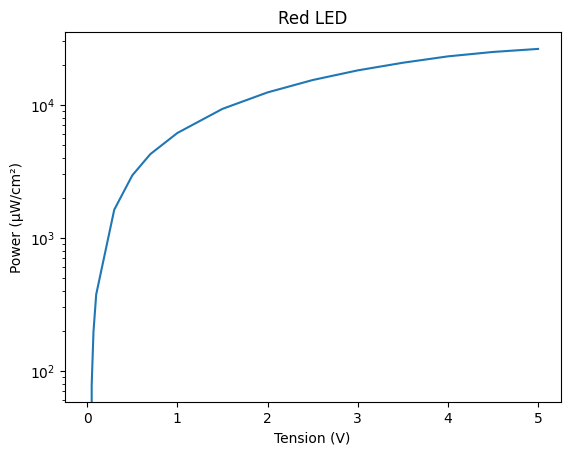

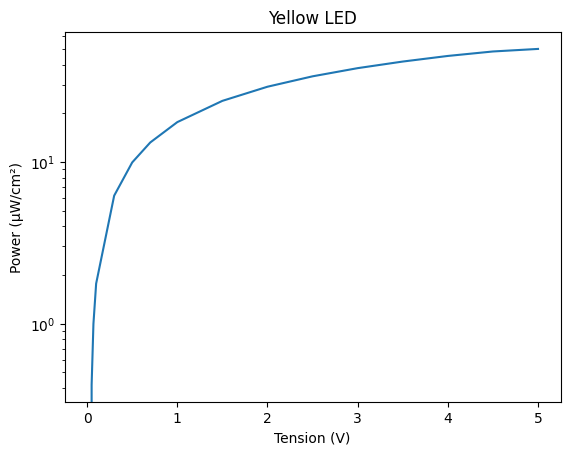

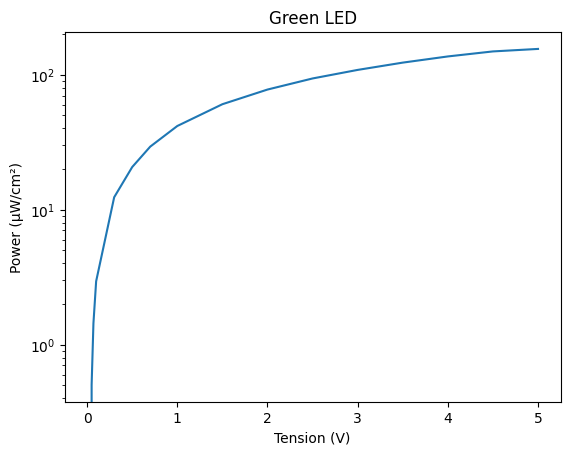

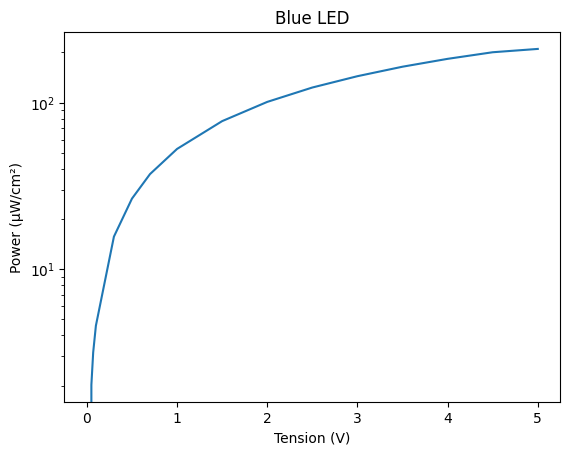

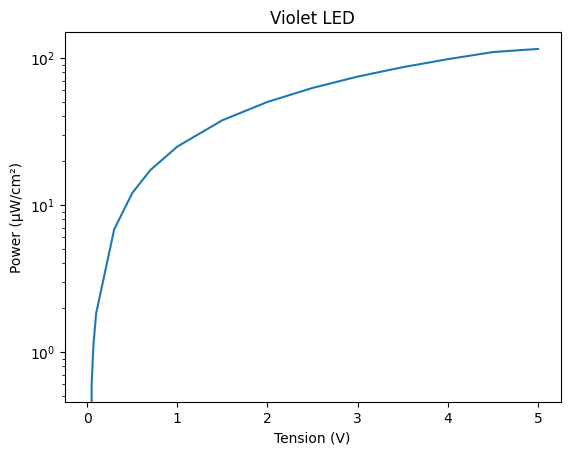

In [13]:
violet_filter = 0.0007448403609977213
yellow_filter = 0.032160625444208

calibration_file = r"./calibration_5_colors_w_MEA_20230403.xlsx"

calibration, _ = charge_calibration(calibration_file, verbose=True)

LED Power Mix:
Violet: 0.38 µW/cm²
Yellow: 2.28 µW/cm²

Ptot with 2 LED Power Values (µW/cm²):
Violet: 0.375
Yellow: 2.284

Isomerisation rate:
Scones: 5.4e+02
Mela: 5.6e+03
Rods: 2.0e+04
Mcones: 1.0e+04
RedOpsin: 1.0e+02


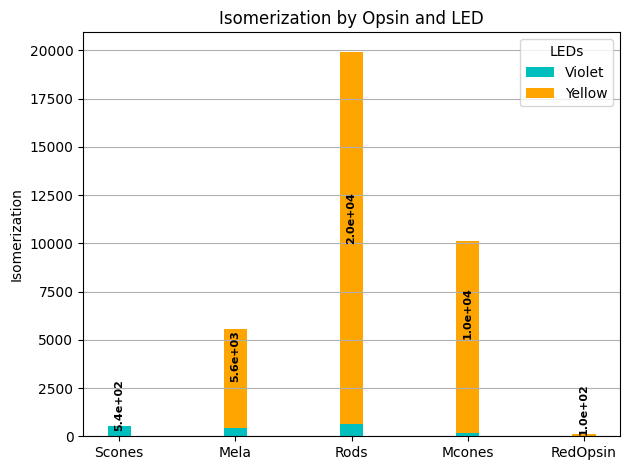

array([0.03150783, 0.12334303])

In [14]:
isomerisation_target = {
    "Scones":5e2,
    "Mcones":1e4,
    'Rods':2e4
}
selected_LEDs = ['Violet', 'Yellow']


Ptot_solution = get_mix_color(isomerisation_target, selected_LEDs = selected_LEDs, ledDATA_path = './IlluminationData.pkl')

plot_isomerisations([Ptot_solution], selected_LEDs = selected_LEDs, colors={'Violet':'c','Yellow':'orange'},ledDATA_path = './IlluminationData.pkl')
plt.show()
plt.close('all')
get_voltages(Ptot_solution, calibration, selected_LEDs)

In [18]:
selected_LEDs = ["Violet", "Blue", "Green", "Yellow", "Red"]

file_path = './Example_PowerList.txt'  # Change this to your file path
output_file_path = file_path.replace('PowerList', 'VoltageList')  # Replace 'PowerList' with 'VoltageList' in the file name
tot=0
with open(file_path, 'r') as file, open(output_file_path, 'w') as output_file:
    for line in file:
        Ptot = list(map(int, line.split()))
        
        # Ensure that the number of columns in the line matches the number of selected LEDs
        assert len(Ptot) == len(selected_LEDs), f"Mismatch: {len(Ptot)} columns in file, but {len(selected_LEDs)} LEDs selected."
        
        voltage = get_voltages(Ptot, calibration, selected_LEDs)  # Assuming get_voltages is defined
        # Write the calculated voltages to the output file in the same format
        output_file.write('\t'.join(map(str, voltage)) + '\n')
        tot+=1
print(f"{tot}Colors written at : \n{output_file_path}")

11Colors written at : 
./Example_VoltageList.txt
